In [1]:
import os
import random
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.metrics import Precision, Recall

import keras_tuner as kt
from keras.optimizers import Adam

In [2]:
top_dir = '/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset'

# Define the training paths
train_dir = os.path.join(top_dir, 'train')

# List all directories in the train directory
all_directories = os.listdir(train_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
train_human = []
train_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        train_ai.append(os.path.join(train_dir, directory))

# Print the lists of directories
print("Train directories containing human-drawn images:")
for i, directory in enumerate(train_human):
    print(f"{i}. {directory}")

print("\nTrain directories containing AI-generated images:")
for i, directory in enumerate(train_ai):
    print(f"{i}. {directory}")

Train directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/realism

Train directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/tr

In [3]:
# Define the test paths
test_dir = os.path.join(top_dir, 'test')

# List all directories in the test directory
all_directories = os.listdir(test_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
test_human = []
test_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        test_ai.append(os.path.join(test_dir, directory))

# Print the lists of directories
print("Test directories containing human-drawn images:")
for i, directory in enumerate(test_human):
    print(f"{i}. {directory}")

print("\nTest directories containing AI-generated images:")
for i, directory in enumerate(test_ai):
    print(f"{i}. {directory}")

Test directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/realism

Test directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_art_n

In [4]:
# Plot k-number of images from the dataset
def plot_im(directory, k):
    files = os.listdir(directory)
    im = random.choices(files, k=k)

    fig = plt.figure()

    for i in range(k):
        im_i_path = os.path.join(directory, im[i])  # File path
        im_i = cv2.imread(im_i_path)
        
        # Add subplot
        ax = fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        
        # Plot image
        ax.imshow(im_i)
        ax.axis('off')
        
        # Display filename below the image
        ax.set_title(im[i], fontsize=8, pad=2)

    plt.tight_layout()  # Adjust layout
    plt.show()

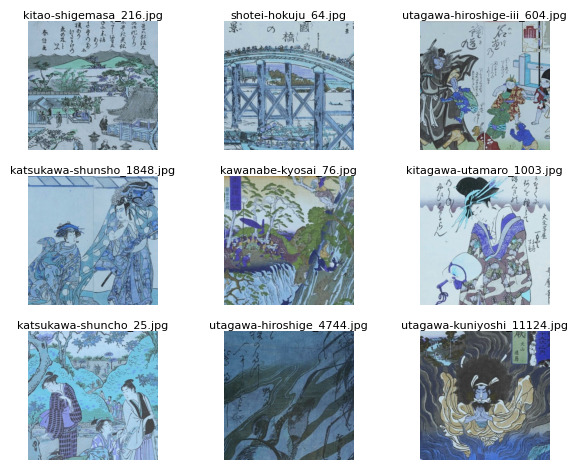

In [5]:
# Visualize random images from train_human. Catagory is sorted in order of output in cell 2
real_im = plot_im(directory=train_human[7], k=9)  
plt.show()

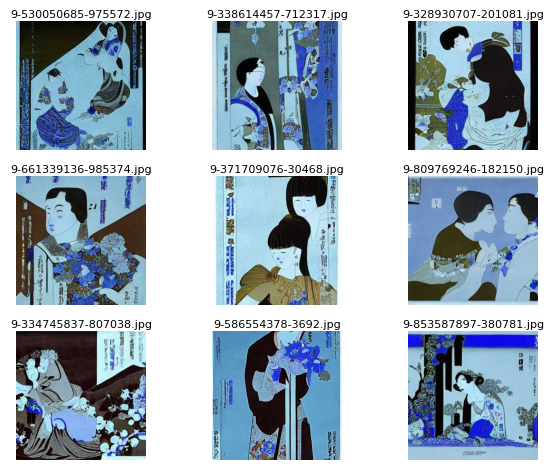

In [6]:
# Visualize random images from train_ai. Catagory is sorted in order of output in cell 2
ai_im = plot_im(directory=train_ai[4], k=9)  
plt.show()

In [7]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for train_data
train_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under train_human as "human"
for directory in train_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under train_ai as "AI"
for directory in train_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with train_data
train_data = pd.concat([train_data, data], ignore_index=True)

In [8]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human


In [9]:
# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("Number of files under each label:")
print(file_counts)

Number of files under each label:
label
AI       105015
human     50000
Name: count, dtype: int64


In [10]:
# Set the random seed for reproducibility
random_seed = 123  # Change this to your desired seed number
np.random.seed(random_seed)

# Number of rows to drop for the 'AI' label
num_to_drop = 55015

# Get the indices of rows with the 'AI' label
ai_indices = train_data[train_data['label'] == 'AI'].index

# Randomly select indices to drop using the specified seed
indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)

# Drop the selected rows from the DataFrame
train_data = train_data.drop(indices_to_drop)

# Reset the index of the DataFrame after dropping rows
train_data.reset_index(drop=True, inplace=True)

In [11]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
human    50000
AI       50000
Name: count, dtype: int64


In [12]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for test_data
test_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under test_human as "human"
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under test_ai as "AI"
for directory in test_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with test_data
test_data = pd.concat([test_data, data], ignore_index=True)

In [13]:
# Display the first few rows of the test_data DataFrame
print(test_data.head())

# Count the number of files under each label
file_counts = test_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
AI       20000
human    10000
Name: count, dtype: int64


In [14]:
# Data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.1
)
train_dataset = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 100000 validated image filenames belonging to 2 classes.


In [15]:
train_dataset.class_indices

{'AI': 0, 'human': 1}

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_dataset = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
test_dataset.class_indices

Found 30000 validated image filenames belonging to 2 classes.


{'AI': 0, 'human': 1}

In [17]:
test_dataset.class_indices

{'AI': 0, 'human': 1}

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization, Dropout, Add, Dense

def build_hybrid_model(input_shape=(128, 128, 3), num_classes=2):
    inputs = keras.Input(shape=input_shape)

    # 📌 Bloc CNN simplifié + GlobalAveragePooling
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.GlobalAveragePooling2D()(x)  # ✅ Remplace Flatten

    # 📌 Transformer amélioré avec normalisation + résidus
    seq = layers.Reshape((1, -1))(x)
    attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(seq, seq)
    attn_output = Add()([seq, attn_output])  # Résidu
    attn_output = LayerNormalization()(attn_output)

    ffn = Dense(64, activation='relu')(attn_output)
    ffn = Dropout(0.3)(ffn)
    transformer = Add()([attn_output, ffn])  # Résidu
    transformer = LayerNormalization()(transformer)
    transformer = layers.Flatten()(transformer)

    # 📌 Fusion CNN + Transformer
    x = layers.Concatenate()([x, transformer])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # ✅ Dropout plus élevé pour éviter overfitting

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model


In [19]:
hybrid_model = build_hybrid_model(input_shape=(128, 128, 3), num_classes=2)
hybrid_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # ← ici on met un float
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2,  # Réduction de la patience
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=1,  # Réduction de la patience pour ajuster plus rapidement
    min_lr=1e-7
)



In [20]:
history = hybrid_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1705s 1s/step - accuracy: 0.7351 - loss: 0.5070 - val_accuracy: 0.8747 - val_loss: 0.2729 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 846s 539ms/step - accuracy: 0.8671 - loss: 0.3073 - val_accuracy: 0.8936 - val_loss: 0.2535 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 845s 539ms/step - accuracy: 0.8992 - loss: 0.2437 - val_accuracy: 0.8774 - val_loss: 0.3073 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 836s 533ms/step - accuracy: 0.9226 - loss: 0.1932 - val_accuracy: 0.8903 - val_loss: 0.3038 - learning_rate: 5.0000e-04


In [21]:
train_loss, train_acc = hybrid_model.evaluate(train_dataset)
test_loss, test_acc = hybrid_model.evaluate(test_dataset)

print(f"✅ Train Accuracy: {train_acc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 734s 468ms/step - accuracy: 0.8994 - loss: 0.2472
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 143s 5ms/step - accuracy: 0.8123 - loss: 0.4207
✅ Train Accuracy: 0.9003
✅ Test Accuracy: 0.8936


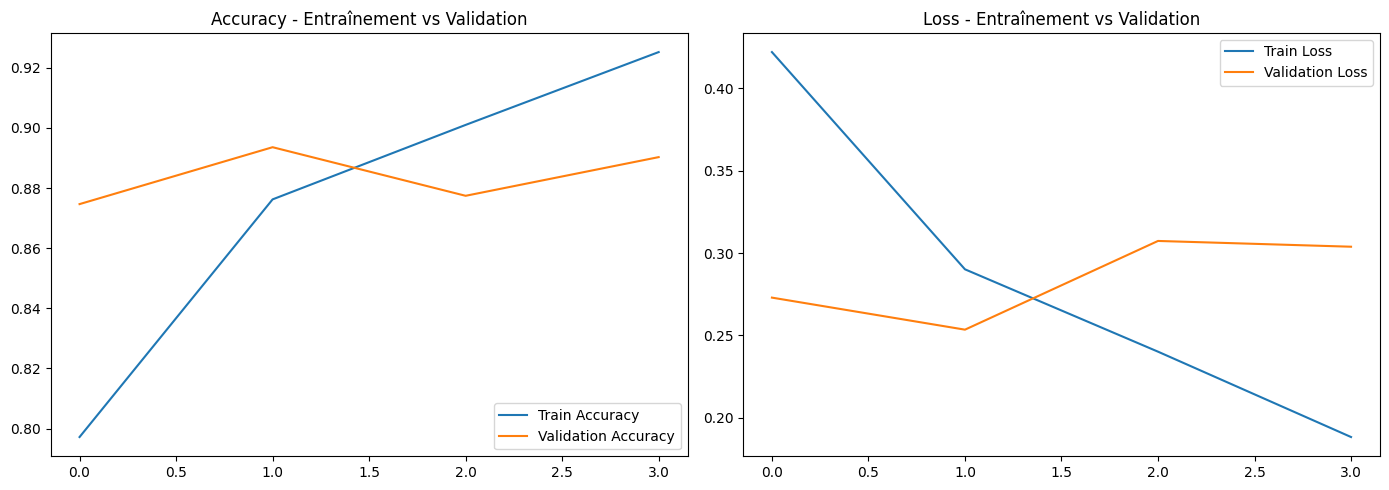

In [22]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # 📈 Courbe d'Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy - Entraînement vs Validation')

    # 📉 Courbe de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss - Entraînement vs Validation')

    plt.tight_layout()
    plt.show()

# Appel de la fonction
plot_training_history(history)


In [26]:
# 💾 Sauvegarde des poids uniquement (fichier léger)
hybrid_model.save_weights("hybrid_model.weights.h5")


In [27]:
# 💾 Sauvegarde de l'architecture uniquement
model_json = hybrid_model.to_json()
with open("hybrid_model_architecture.json", "w") as json_file:
    json_file.write(model_json)
